In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from dateutil.relativedelta import relativedelta
import altair as alt

In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\Users\Jason\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [3]:
# Ignoring warnings only due to it not liking a df being overwritten insteady of a shallow copy when merging
import warnings
warnings.filterwarnings("ignore")

# Initial Inputs/ Assumptions

In [4]:
# Import the test data set for the current strategy
# Import ticker data for 
price_hist = pd.read_csv('Excel_data/test_60_40_advanced.csv')
predictions = pd.read_csv('Excel_data/Predictions_best_tune.csv')
start_date = '2019-12-01' # This date is typically 1 month before the start date (see below). This givces rolling data into the trade window
strategy_start = '2020-01-01'
tspan = 3 # 3 years 
test = datetime.strptime(start_date, '%Y-%m-%d')+relativedelta(years=1) # this is useful 

# Default Benchmark Strategy
Equity = 0.6
Debt = 0.4

# Trade Strategy based on model predictions
Equity_adj = 0.80 # This is the maximum upweight amount 
#
# Risk Free Treasury Rates - For use in Sharpe, Average

#rf_rate = np.mean([.0155,.0009, .0008,0.045])*100 # averaging from Jan 2020 to Dec 31, 2023 in this scenario
rf_rate = .01

# List of Tickers generated from the Fetch ETF Data File, These need to match

ticker_test = ['SPY','XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE','TLT','HYXF','SJNK','SPTI','LQD']

# Split into Equities and Bonds
equity_tickers = ['SPY','XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE']
bond_tickers = ['TLT','HYXF','SJNK','SPTI','LQD']

# Functions

In [6]:
# filters data to only the trading timespan

def trade_timespan(start_date,tspan):
    trade_years = []
    for i in range(0,tspan+1):
        temp =  datetime.strptime(start_date, '%Y-%m-%d')+relativedelta(years=i)
        temp = temp +relativedelta(months=1)
        yr = str(temp.date())
        trade_years.append(yr)
    return trade_years

In [7]:
# gets price history 
def price_extractor(ticker_test,price_hist):
    t_vec = ['Date']
    for i in ticker_test:
        t = ((i)+'_Adj Close')
        t_vec.append(t)
    return t_vec

In [8]:
# sets the portfolio weights based on trade strategy
def portfolio_weights(predictions,Equity_adj):
    predictions =predictions.copy()
    predictions['Equity'] = Equity_adj
    predictions['Equity_Base']=Equity_adj
    predictions.loc[predictions['Prediction'] == 0, 'Equity'] = 1-Equity_adj
    predictions.loc[predictions['Base_Prediction'] == 0, 'Equity_Base'] = 1-Equity_adj
    predictions['Debt'] = 1-predictions['Equity']
    predictions['Debt_Base'] = 1-predictions['Equity_Base']

    return predictions

In [9]:
# gets back testing data and fills in gaps between trading ranges with the static strategy 
def backtest_func(data,df,start_date,strategy_start):
    backtest = (data[data['Date']>=start_date]).copy()
    backtest = pd.merge(backtest,df, how='left', on = 'Date', suffixes = ('_left', '_right'))
    # add in fed dates
    backtest.fillna(method='ffill', inplace=True)
    backtest = backtest[backtest['Date']>=strategy_start]

    return backtest

In [10]:
def stategy_calculator(backtest,strategy_start,Equity,Debt,equity_tickers,bond_tickers):
    backtest = backtest.copy()

    for i in equity_tickers:
        backtest[str(i)+'_change'] = backtest[i+'_Adj Close'].pct_change()
        backtest[str(i)+'_agg'] = backtest[str(i)+'_change'].cumsum()
        backtest[str(i)+'_weighted']=backtest['Equity']*backtest[str(i)+'_change']
        ### Do the same for the base strategy to find base portfolio weights
        backtest[str(i)+'_weighted_base']=backtest['Equity_Base']*backtest[str(i)+'_change']
        backtest[str(i)+'_standard']=Equity*backtest[str(i)+'_change']

    for j in bond_tickers:
        backtest[str(j)+'_change'] = backtest[j+'_Adj Close'].pct_change()
        backtest[str(j)+'_agg'] = backtest[str(j)+'_change'].cumsum()
        backtest[str(j)+'_weighted']=backtest['Debt']*backtest[str(j)+'_change']
        ### Do the same for the base strategy to find base portfolio weights
        backtest[str(j)+'_weighted_base']=backtest['Debt_Base']*backtest[str(j)+'_change']
        backtest[str(j)+'_standard']=Debt*backtest[str(j)+'_change']

    backtest = backtest[backtest['Date']>=strategy_start]
   
    i = []
    j = []
    for i in equity_tickers:
        for j in bond_tickers:
            backtest[str(i)+'_'+str(j)+' Optimized_Return'] = backtest[str(i)+'_weighted']+backtest[str(j)+'_weighted']
            backtest[str(i)+'_'+str(j)+' Optimized_Return_Base'] = backtest[str(i)+'_weighted_base']+backtest[str(j)+'_weighted_base']
            backtest[str(i)+'_'+str(j)+' Standard_Return'] = backtest[str(i)+'_standard']+backtest[str(j)+'_standard']

    i = []
    j = []
    
    opt_agg_list = []
    std_agg_list = []

    for i in equity_tickers:
        for j in bond_tickers:
            backtest[str(i)+'_'+str(j)+' Optimized_Agg'] =backtest[str(i)+'_'+str(j)+' Optimized_Return'].cumsum()
            backtest[str(i)+'_'+str(j)+' Optimized_Agg_Base'] =backtest[str(i)+'_'+str(j)+' Optimized_Return_Base'].cumsum()
            opt_agg_list.append(str(i)+'_'+str(j)+' Optimized_Agg')
            backtest[str(i)+'_'+str(j)+' Standard_Agg'] =backtest[str(i)+'_'+str(j)+' Standard_Return'].cumsum()
            std_agg_list.append(str(i)+'_'+str(j)+' Standard_Agg')

    return backtest,opt_agg_list,std_agg_list

In [11]:
def top_performers(backtest,list1,top_groups): # need to add second list of standard returns. 
    cols = backtest[list1]
    df = cols[cols.iloc[-1].nlargest(top_groups).index]
    column_list = df.columns.to_list()

    temp_list = []
    temp_list2 = []
    for i in column_list:
        temp = i.split(' ')[0]
        var1 = str(temp) +' Standard_Agg'
        var2 = str(temp) +' Optimized_Agg_Base'
        temp_list.append(var1)
        temp_list2.append(var2)
    list_out = list(zip(column_list,temp_list,temp_list2))
    
    return list_out

In [12]:
# Sharpe Ratio
def Sharpe_func(df,rf_rate,trade_years,tops):

    iz = tops[0][0]
    
    spt = iz.split()

    back_strings = [' Optimized_Return', ' Optimized_Return_Base', ' Standard_Return']
    string_holder = []
    for i in back_strings:
        combine = spt[0]+i
        string_holder.append(combine)


    opt = string_holder[0]
    standard = string_holder[2]
    opt_base = string_holder[1]


    opt_sigma = []
    st_sigma = []
    spy_sigma = []
    opt_ret = []
    st_ret = []
    spy_ret = []
    opt_sharpe = []
    st_sharpe = []
    passive_sharpe = []

    for i in range(0,len(trade_years)):

        if i < len(trade_years)-1:
            temp_df = df[(df['Date']>= trade_years[i]) & (df['Date'] <= trade_years[i+1])]
   
            opt_temp =(temp_df[opt].sum())/len(temp_df[opt])
           
            std_temp =(temp_df[opt_base].sum()/len(temp_df[opt_base]))

            spy_temp = (temp_df[standard].sum())/len(temp_df[standard])


            
            sigma_opt = (temp_df[opt].std())*(len(temp_df[opt])**.5)
            sigma_bench = (temp_df[opt_base].std())*(len(temp_df[opt_base])**.5)
            sigma_spy = (temp_df[standard].std())*(len(temp_df[opt_base])**.5)

            # returns list
            opt_ret.append(opt_temp)
            st_ret.append(std_temp)
            spy_ret.append(spy_temp)

            # standard dev list
            opt_sigma.append(sigma_opt)
            st_sigma.append(sigma_bench)
            spy_sigma.append(sigma_spy)

            #Sharpe List
            opt_sharpe.append((opt_temp*252-rf_rate)/(sigma_opt))
            st_sharpe.append(((std_temp*252-rf_rate)/sigma_bench))
            passive_sharpe.append(((spy_temp*252-rf_rate)/sigma_spy))


    return (opt_sharpe,st_sharpe,passive_sharpe)

In [13]:
def return_calcs(s_ratios):

    nlp_sharpe_avg = np.sum(s_ratios[0])/len(s_ratios)
    base_sharpe_avg = np.sum(s_ratios[1])/len(s_ratios)
    sp500_sharpe_avg=np.sum(s_ratios[2])/len(s_ratios)

    # Quick output of Sharpe Comparison 
    print('NLP Porftolio-Sharpe Year Over Year ',s_ratios[0])
    print('\n')
    print('Non NLP Porftolio-Sharpe Year Over Year',s_ratios[1])
    print('\n')
    print('Passive Sharpe Year Over Year',s_ratios[2])
    print('\n')
    print('3 Year Avg NLP Portfolio.',nlp_sharpe_avg,'\n','3 Year Avg No NLP Portfolio.',base_sharpe_avg,'\n','3 Year AVG 60/40 Passive.',sp500_sharpe_avg)

    return

In [14]:
def trade_plotter(backtest,df, tops,predictions,y_lower,y_upper):
    
    f, ax = plt.subplots(figsize = [15, 7])
    years =pd.to_datetime(backtest['Date']).dt.year



    for i in tops:
            a = i[0]
            b = i[1]
            c = i[2]
    
            te = (a).strip()
            


            ax.plot(pd.to_datetime(backtest['Date']), backtest[str(b)]*100, label='Passive Return', color = 'k') # 60/40 portfolio
            ax.plot(pd.to_datetime(backtest['Date']), backtest[str(a)]*100, label='Optimized Return with NLP') # was label b
            ax.plot(pd.to_datetime(backtest['Date']), backtest[str(c)]*100, label ='Optimized Return Benchmark') # was label c label=str(c)+' Optimized Return_Base


    # Set Plot Ranges    
    min_y = y_lower
    max_y = y_upper

    ax.set_ylim(min_y, max_y)
    ax.set_xlim(pd.to_datetime(backtest['Date']).min(),pd.to_datetime(backtest['Date']).max() )
    ax.legend(loc = 'upper left')
    plt.title('Portfolio Aggregate Return Comparison',fontsize=20)
    plt.xlabel('Year',fontsize = 15)
    plt.ylabel('Aggregate Return (%)',fontsize=15)



    # Prediction analysis for plotting vertical lines
    predictions['shifted_date'] = predictions['Date'].shift(1) # this shifts one month to the left 
    predict_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear'])]
    predict_bull_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear']) & (predictions['Prediction']==1)]
    base_error = predictions[(predictions['Base_Prediction']!= predictions['Prediction'])]


    # date ranges for the above predictions for plotting

    date_list2 =list(predict_error['Date'])
    date_list3 = list(predict_error['shifted_date'])
    date_list4 = list(df['Date'])
    date_list5 = list(predict_bull_error['Date'])
    date_list6 = list(predict_bull_error['shifted_date'])

  
    date_list7 = list(base_error['Date'])
    date_list8 = list(base_error['shifted_date'])
   
    for l in date_list4[2:]:
            ax.axvline(pd.to_datetime(l), color='k', alpha = 0.35)
            plt.text(pd.to_datetime(l),min_y+0.02,str(l),rotation=90,alpha = 0.25)


    for (j,k) in zip(date_list2,date_list3):
    
            ax.axvspan(pd.to_datetime(k), pd.to_datetime(j), ymin=0, ymax=1,color = 'red',alpha = 0.25)

    for (a,b) in zip(date_list5,date_list6):
          
            ax.axvspan(pd.to_datetime(b), pd.to_datetime(a), ymin=0, ymax=1,color = 'red',alpha = 0.45)

    for (m,n) in zip(date_list7,date_list8):
           
    
            ax.axvspan(pd.to_datetime(n), pd.to_datetime(m), ymin=0, ymax=1,color = 'gray',alpha = 0.35)




    ax.annotate('Covid', xy=(pd.to_datetime(date_list3[0]), 0.25), xytext=(pd.to_datetime(date_list3[0]), 20))
    ax.annotate('War in Ukraine', xy=(pd.to_datetime(date_list3[3]),.5), xytext=(pd.to_datetime(date_list3[3]), 10),fontsize=10)

    return

In [15]:
def Trade_RUN(ticker_test,price_hist,predictions,Equity_adj,start_date,strategy_start,Equity,Debt,equity_tickers,bond_tickers):
    
    
    ticker_vec = price_extractor(ticker_test,price_hist)

    # include the columns you want based on tickers provided from the price_extractor function
    price_hist = price_hist[price_hist.columns[price_hist.columns.isin(ticker_vec)]]


    df = portfolio_weights(predictions,Equity_adj) # Adjust Trade Strategy Weights


    backtest = backtest_func(price_hist,df,start_date,strategy_start)
    bt = stategy_calculator(backtest,strategy_start,Equity,Debt,equity_tickers,bond_tickers)


    backtest = bt[0] # extracts dates for Trading stategy
    list1 = bt[1] # gets optimized portfolio aggregate return
    list2 = bt[2] # gers standard aggregate return
    test =backtest[['Equity','Equity_Base']]
    backtest['Meeting'] = backtest['Date'].isin(df['Date']).astype(int)

    # find predeeding dates for plotting aka what was our prediction the month prior
    predict_error = predictions[(predictions['Prediction']!= predictions['Bull_Bear'])]
    predict_error2 = predictions[(predictions['Prediction']!= predictions['Bull_Bear'])|(predictions['Base_Prediction']!= predictions['Bull_Bear'])]

    # Used for Report Plotting
    predict_error_table = predict_error2
    predict_error_table['Bull_Bear'].astype(int)
    predict_error_table.reset_index(drop=True)

    return backtest,list1,df


# The Following Cells Run the Trading Strategy

Confirming Trade Prediction Years

In [16]:
trade_years = trade_timespan(start_date,tspan)
trade_years

['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01']

## Run This Cell to Conduct Trading

In [17]:
trading_results = Trade_RUN(ticker_test,price_hist,predictions,Equity_adj,start_date,strategy_start,Equity,Debt,equity_tickers,bond_tickers)
trading_df = trading_results[0]
list1 = trading_results[1]
price_df = trading_results[2]


# Extract Top ETF Trading Parings

You can pick how many to ouptut based on top_groups

In [18]:
top_groups = 2
tops = top_performers(trading_df,list1,top_groups)

#Printing out the top pairings in terms of total return
tops



[('XLE_SJNK Optimized_Agg',
  'XLE_SJNK Standard_Agg',
  'XLE_SJNK Optimized_Agg_Base'),
 ('XLE_TLT Optimized_Agg',
  'XLE_TLT Standard_Agg',
  'XLE_TLT Optimized_Agg_Base')]

The Line Below Is a manual override to not plot all of the top tickers or select a specific group

Currently set to the SPY-TLT combination used as the baseline strategy in the report

In [19]:
tops = [('SPY_TLT Optimized_Agg',
  'SPY_TLT Standard_Agg',
  'SPY_TLT Optimized_Agg_Base')]

# Plotting & Sharpe Ratio Analysis

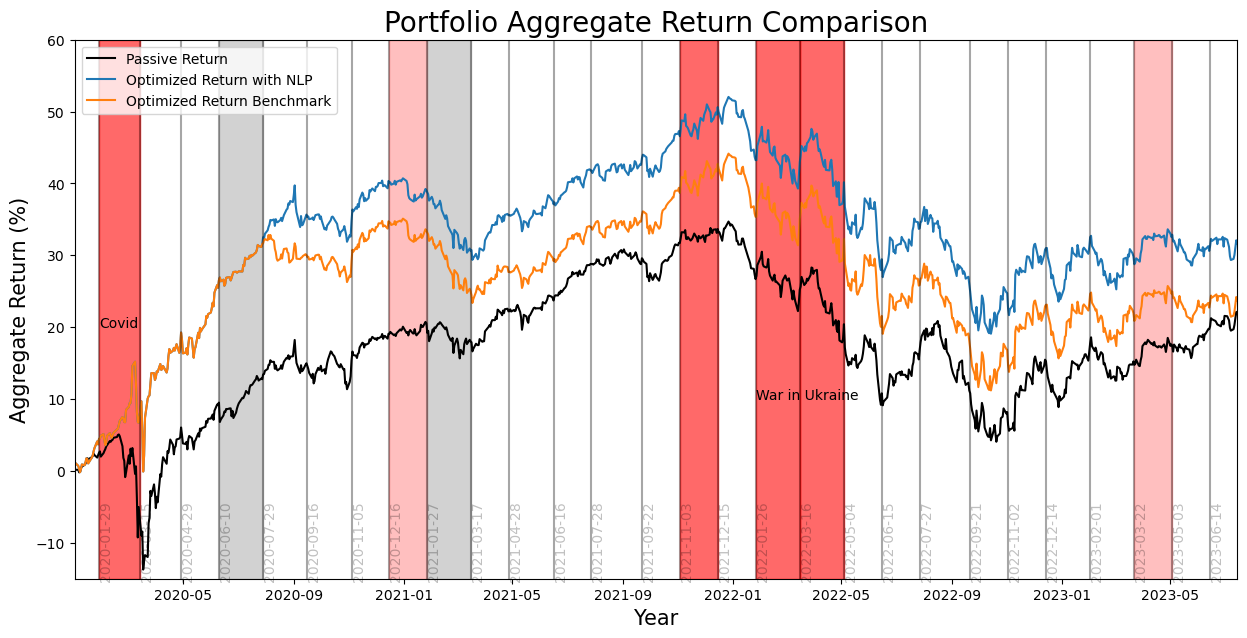

In [20]:
# Set y axis window -- hard to to automatically with all the different combinations
y_lower = -15
y_upper = 60

fig = trade_plotter(trading_df,price_df,tops,predictions,y_lower,y_upper)


In [21]:
# Quick Output of Year over Year Sharpe Ratios and Returns
s_ratios = Sharpe_func(trading_df,rf_rate,trade_years,tops)
return_calcs(s_ratios)

NLP Porftolio-Sharpe Year Over Year  [2.4531653302138237, 0.9292265108769793, -1.4568262955279234]


Non NLP Porftolio-Sharpe Year Over Year [2.155371908894819, 0.7106352181777337, -1.4568262955279234]


Passive Sharpe Year Over Year [1.0737165484271898, 1.47336113973535, -1.4790405854851183]


3 Year Avg NLP Portfolio. 0.6418551818542931 
 3 Year Avg No NLP Portfolio. 0.46972694384820973 
 3 Year AVG 60/40 Passive. 0.3560123675591406
